In [1]:
import sklearn.metrics as mets
import sklearn.model_selection
import numpy as np
import os
from collections import defaultdict
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, bisect, curve_fit
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from functools import partial, reduce
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import datetime
import multiprocessing
from pathlib import Path
import sys
sys.path.insert(0,'C:\\Users\\raul\\Documents\\workspace\\MAI\\Riskconcile\\riskconcile')
sys.path.insert(0,'/vsc-hard-mounts/leuven-data/335/vsc33596/workspace/riskconcile/')
from tools.utils import fft_price
import gc
%load_ext tensorboard
tf.keras.backend.set_floatx('float32')
np.random.seed(1)
i = complex(0,1)

In [2]:
print("tensor flow version: ", tf.__version__)
print("Is there a GPU available: "),
print(tf.config.list_physical_devices('GPU'))

tensor flow version:  2.1.0
Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def plot_params(params,data):
    '''This function plots the curves of a given calibration with different maturities'''
    sig, th, ka, rho, eta = params
    S0 = data.price.mean()
    T = data.time_maturity.unique()
    r = [data.rate.mean()]*len(T)
    q = [0]*len(T)
    mink = data.strike.min()
    maxk = data.strike.max()
    K = list(range(int(np.floor(mink)),int(np.ceil(maxk))))

    Y_call = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Heston', callput='c',diag=False,
              sig = sig,th=th,ka=ka,rho=rho,eta=eta)

    Y_put = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Heston', callput='p',diag=False,
              sig = sig,th=th,ka=ka,rho=rho,eta=eta)
    
    fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
    n_times = len(T)
    df_plot = pd.DataFrame()
    df_plot['strike'] = K*n_times
    df_plot['eu_price'] = Y_call.reshape(-1,)
    df_plot['putp'] = Y_put.reshape(-1,)
    inter_time = len(K)
    df_plot['Time Maturity'] = reduce(lambda x,y:x+y,[[x]*inter_time for x in T])

    ## Plot call prices
    sns.lineplot(x="strike", y="eu_price", hue="Time Maturity", data=df_plot, legend = 'full', 
                 palette=sns.color_palette("Blues_d", n_times))
    sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=data[data.call_put == 'C'],
                    legend= False,palette=sns.color_palette("Blues_d", len(data[data.call_put == 'C'].time_maturity.unique())))


    ## Plot put prices
    sns.lineplot(x="strike", y="putp", hue="Time Maturity", data=df_plot, legend = False,
                 palette=sns.color_palette("Greens_d", n_times))
    sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=data[data.call_put == 'P'],
                    legend= False,palette=sns.color_palette("Greens_d", len(data[data.call_put == 'P'].time_maturity.unique())))

    plt.title("%s: Theoretical vs Real values" % data.underlying.iloc[0])
    plt.axvline(S0,color='#591818')
    ax = plt.gca()
    ax.set_xticks([mink, maxk, S0])
    ax.set_xticklabels([mink, maxk,"s0"])
    display(fig)
    plt.close(fig)
    
    
def residual_interp(params, t, Y):
    '''
    Residual function for the Log interpolation.
    '''
    a, b, c, d = params

    return a+b*np.log(c*(t+d))-Y

def get_loginterp(x0,bnd,t, Y):
    '''
    Wrapper for gradient-based least squares optimization on the log inter/exrapolation.
    '''
    t0 = time()
    bounds = ([-np.inf,-np.inf,1e-10,-bnd],[np.inf,np.inf,np.inf,np.inf])
    res = least_squares(residual_interp, x0,args=(t, Y), method="trf", bounds = bounds,
                        max_nfev=300,jac="2-point",loss="linear", tr_solver="exact")

    t1 = time()
#     print("Scipy time: ", t1-t0)
    def log_inter(x, pvals):
        return pvals[0]+pvals[1]*np.log(pvals[2]*(x+pvals[3]))
    
    return partial(log_inter,pvals=res.x)

# Loading the data

In [16]:
def drop_tails(df, 
               columns=['strike', 'eu_price', 'iv', 'time_maturity','rate', 'dividend'], 
               limitstd=3):
    usesful_cols = df.std()[(df.std() != 0)]
    columns = [x for x in columns if x in usesful_cols]
    z = np.abs(stats.zscore(df[columns]))
    return df[(z < limitstd).all(axis=1)]

def robust_interpolation(x,interpolations):
    interp_obj = interpolations[x[0]]
    if interp_obj == 0:
        return 0
    else:
        return interp_obj(x[1])

def get_file_name(files,name):
    return [x for x in files if name in x][0]


def interp_dict(data, group, x_inter, y_inter, log_inter=False):
    interpolations =  defaultdict(lambda:0)
    fail = []
    for x in data.groupby(group)[[x_inter, y_inter]]:
        if len(x[1])>5:
            if log_inter:
                interpolations[x[0]] = interp1d(x[1][x_inter],x[1][y_inter], kind='nearest',fill_value="extrapolate")
#                 interpolations[x[0]] = get_loginterp((.0, .01, .001, 0), (x[1][x_inter].min()-1e-10),
#                                                      x[1][x_inter], x[1][y_inter])
                
            else:
                interpolations[x[0]] = interp1d(x[1][x_inter],x[1][y_inter], kind='quadratic',fill_value="extrapolate")
        else:
            fail.append(x[0])
    return interpolations

def interpolate_by_groups(df, col2interp, interp_df, group4interp, x_inter, y_inter, log_inter=False):
    interpolations = interp_dict(interp_df, group4interp, x_inter, y_inter, log_inter)
    
    return df[[group4interp,col2interp]].apply(partial(robust_interpolation,
                                                       interpolations= interpolations), axis=1)
    

def get_data_folder(folder, filter_index=False):
    """
    Get and process the data from a given folder.

    :folder: A folder that contains the dividend, interests, option and
    spot DataFrame
    :filter_index: If required a list of index can be provided to exclude
    a set of values
    """
    files = os.listdir(folder)
    trading_days = 365
    dividendsdf = pd.read_csv(
        folder + get_file_name(files, 'dividend'), index_col=0)
    interestdf = pd.read_csv(folder + get_file_name(files, 'interest_rate'))
    optionsdf = pd.read_csv(folder + get_file_name(files, 'option'))
    optionsdf = optionsdf[optionsdf.open_interest != 0]
    spotdf = pd.read_csv(folder + get_file_name(files, 'spot'))
    # adjusting coluns for dividends
    dividendsdf.reset_index(inplace=True)
    dividendsdf.rename(columns={'tenor_date': 'expiration',
                                'dividend_yield': 'dividend'
                                }, inplace=True)
    df = optionsdf[['date', 'strike', 'eu_price',
                    'underlying', 'iv', 'call_put', 'expiration']].copy()
    # Computing maturity
    df.loc[:, 'time_maturity'] = (pd.to_datetime(
        optionsdf.expiration) - pd.to_datetime(optionsdf.date)).astype(
        'timedelta64[D]')/trading_days
    print("Initial number of rows: ", len(optionsdf))
    # Computing dividend yield
    df = df.merge(dividendsdf, on=['date', 'underlying', 'expiration']).copy()
    print("Number of rows after merging", len(df))
    df.drop('expiration', axis=1, inplace=True)
    # Dropping nans
    df.dropna(inplace=True)
    print("Number of rows after dropping nans", len(df))
    if filter_index:
        df = df.loc[filter_index]

    df.loc[:, 'rate'] = interpolate_by_groups(df, 'time_maturity', interestdf,
                                              'date', 'tenor_float', 'rate')
    print("before interpolaion", len(df))
    df = df.merge(spotdf[['date', 'underlying', 'price']],
                  on=['date', 'underlying'], how='left').copy()
    print("after merging spot", len(df))
    df.dropna(inplace=True)
    print("Number of removed rows after dropping NA: ", len(df))

    # Removal of 0s in prices
    df = df[df.eu_price > 0]
    print("Number of removed rows after dropping 0s in EU prices: ", len(df))
    # Removal of too short maturities
    df = df[df.time_maturity >= 15/trading_days]
    print("Number of removed rows after dropping maturities below one month: ",
          len(df))
    df.loc[:, 'moneyness'] = df['price']/df['strike']
    df = df[df.moneyness < 3]
    print("Number of removed rows after cleaning moneyness: ", len(df))
    z = np.abs(stats.zscore(
        df[['strike', 'eu_price', 'iv', 'time_maturity', 'rate', 'dividend']]))
    df_cleaniqr = df[(z < 3).all(axis=1)]
    print("Final number number of rows afer the 'Z score' outlier detection: ",
          len(df_cleaniqr))
    df_cleaniqr.loc[:, 'day_values'] = 1
    agg_df = df_cleaniqr.groupby(['underlying', 'date']).count()[
        ['day_values']].copy()
    df_cleaniqr.drop('day_values', axis=1, inplace=True)
    agg_df.reset_index(inplace=True)
    df_cleaniqr = df_cleaniqr.merge(agg_df, on=['underlying', 'date']).copy()
    df_cleaniqr = df_cleaniqr[df_cleaniqr.day_values > 80]
    df_cleaniqr.drop('day_values', axis=1, inplace=True)
    print("Number of rows after discarding days with little data",
          len(df_cleaniqr))
    del dividendsdf, interestdf, optionsdf, spotdf, df, agg_df
    gc.collect()
    return df_cleaniqr

In [23]:
folder = '../../data/4rth/'
data = get_data_folder(folder,False)

Initial number of rows:  288468
Number of rows after merging 118529
Number of rows after dropping nans 106488
before interpolaion 106488
after merging spot 106488
Number of removed rows after dropping NA:  106488
Number of removed rows after dropping 0s in EU prices:  89371
Number of removed rows after dropping maturities below one month:  56060
Number of removed rows after cleaning moneyness:  56055
Final number number of rows afer the 'Z score' outlier detection:  53438
Number of rows after discarding days with little data 52898


C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in

In [22]:
# train_sample = data.sample(frac = .75).index
# train_data = data.loc[train_sample]
# test_data = data.loc[set(data.index)-set(train_sample)]
# train_data.to_csv('../data/first_batch/train.csv')
# test_data.to_csv('../data/first_batch/test.csv')

In [18]:
# train_group = []
# test_group = []
# for _,underlying_data in data.groupby('underlying'):
#     for _, date_data in underlying_data.groupby('date'):
#         train_sample = date_data.sample(frac = .75).index
#         train_group.append(date_data.loc[train_sample])
#         test_group.append(date_data.loc[set(date_data.index)-set(train_sample)])
# trainf_df = pd.concat(train_group,axis=0)
# test_df = pd.concat(test_group,axis=0)
# trainf_df.to_csv('../data/second_batch/train.csv')
# test_df.to_csv('../data/second_batch/test.csv')

In [24]:
files = os.listdir(folder)
dividendsdf = pd.read_csv(folder + get_file_name(files, 'dividend'), index_col=0)
interestdf = pd.read_csv(folder + get_file_name(files, 'interest_rate'))
optionsdf = pd.read_csv(folder + get_file_name(files, 'option'))
optionsdf = optionsdf[optionsdf.open_interest != 0]
spotdf = pd.read_csv(folder + get_file_name(files, 'spot'))
dividendsdf.reset_index(inplace=True)
dividendsdf.rename(columns={'tenor_date':'expiration'}, inplace=True)

# Implementing the CalNet

## Input layer for the BackwardPass

In [25]:
class Input_layer(layers.Layer):

    def __init__(self, num_params, num_envals, **kwargs):
        super(Input_layer, self).__init__(**kwargs)
        # Create a trainable input layer
        self.paramets = tf.Variable(initial_value=tf.ones((1,num_params),dtype='float32'),
                                    trainable=True,name='Heston_parameters', dtype='float32',)
#                                     constraint=lambda x: tf.clip_by_value(x, 0, 1))
        # Neuron for the Strike, Spot, etc -> we never train this layer
        self.envars = tf.Variable(initial_value=tf.ones((1,num_envals),dtype='float32'),
                             trainable=False, name='envar',dtype='float32')
        #self.first_lay = tf.concat([self.paramets,self.envars],1)

    def call(self, inputs):
        first_lay = tf.concat([self.paramets,self.envars],1)
        return tf.multiply(inputs, first_lay) 



In [26]:
class Calnet(tf.keras.Model):
    """End-to-end model for training."""

    def __init__(self,
               num_params,
               num_envals,
               name='calnet',
               **kwargs):
        super(Calnet, self).__init__(name=name, **kwargs)
        self.num_params = num_params
        self.num_envals = num_envals
        self.in_layer = Input_layer(num_params, num_envals)
        self.d1 = Dense(400, activation=tf.nn.leaky_relu,)
        self.d2 = Dense(400, activation=tf.nn.leaky_relu,)
        self.d3 = Dense(400, activation=tf.nn.leaky_relu,)
        self.d4 = Dense(400, activation=tf.nn.leaky_relu,)
        self.d5 = Dense(400, activation=tf.nn.leaky_relu,)
        self.regression = Dense(1, activation='linear')
    
    def call(self, x):
        x = self.in_layer(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        return self.regression(x)

In [27]:
loss_object = tf.keras.losses.MeanSquaredError()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_mae')
train_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='train_mape')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')
test_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='test_mape')

bw_loss = tf.keras.metrics.Mean(name='bw_loss')
bw_mae = tf.keras.metrics.MeanAbsoluteError(name='bw_mae')
bw_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='bw_mape')

bw_test_loss = tf.keras.metrics.Mean(name='test_loss')
bw_test_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')
bw_test_mape = tf.keras.metrics.MeanAbsolutePercentageError(name='test_mape')
# custom_metrics = {'MAE' : tf.keras.metrics.MAE,
#                   'MAPE' : tf.keras.metrics.MAPE}

#### Train Step

In [28]:
# Train Step
@tf.function
def train_step(data, target):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        loss = loss_object(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables[1:])
#     gradients = [tf.clip_by_value(grad, -1., 1.) for grad in gradients]
    optimizer.apply_gradients(zip(gradients, model.trainable_variables[1:]))#,global_step=global_step)

    train_loss(loss)
    train_mae(target, predictions)
    train_mape(target, predictions)


#### Test Step

In [29]:
@tf.function
def test_step(data, target):
    predictions = model(data, training=False)
    t_loss = loss_object(target, predictions)

    test_loss(t_loss)
    test_mae(target, predictions)
    test_mape(target, predictions)
    
@tf.function
def test_step_bw(data, target):
    predictions = model(data, training=False)
    t_loss = loss_object(target, predictions)

    bw_test_loss(t_loss)
    bw_test_mae(target, predictions)
    bw_test_mape(target, predictions)

#### Backward Step

In [30]:
# Train Step
bw_opimizer = tf.keras.optimizers.Adam()

@tf.function
def backward_step(data, target):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        loss = loss_object(target, predictions)
    gradients = tape.gradient(loss, [model.trainable_variables[0]])
#     capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    bw_opimizer.apply_gradients(zip(gradients,[model.trainable_variables[0]]))

    bw_loss(loss)
    bw_mae(target, predictions)
    bw_mape(target, predictions)


In [31]:
model = Calnet(5,4)
train_ds = tf.random.uniform([100,9])
model(train_ds)

model.summary()

Model: "calnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Input_layer)    multiple                  9         
_________________________________________________________________
dense (Dense)                multiple                  4000      
_________________________________________________________________
dense_1 (Dense)              multiple                  160400    
_________________________________________________________________
dense_2 (Dense)              multiple                  160400    
_________________________________________________________________
dense_3 (Dense)              multiple                  160400    
_________________________________________________________________
dense_4 (Dense)              multiple                  160400    
_________________________________________________________________
dense_5 (Dense)              multiple                  401  

In [32]:
model.load_weights('../../logs/model_checkpoints/20200413-154905_radamLAhead/epoch_900.h5')

In [33]:
print('Parameter layer')
print(model.layers[0].weights[0].numpy())
print('Hidden layer weights')
print(model.layers[1].weights[0].numpy()[0][:10])

Parameter layer
[[1. 1. 1. 1. 1.]]
Hidden layer weights
[-0.01944916  0.27069175  0.13990346 -0.17453998 -0.05319062 -0.07571768
 -0.22104616  0.18629277  0.33032075  0.5243865 ]


### Iteration Backward Step

In [35]:
datadata = get_data_folder(folder)

Initial number of rows:  288468
Number of rows after merging 118529
Number of rows after dropping nans 106488
before interpolaion 106488
after merging spot 106488
Number of removed rows after dropping NA:  106488
Number of removed rows after dropping 0s in EU prices:  89371
Number of removed rows after dropping maturities below one month:  56060
Number of removed rows after cleaning moneyness:  56055
Final number number of rows afer the 'Z score' outlier detection:  53438
Number of rows after discarding days with little data 52898


Text(0.5, 1.0, 'Interest rate')

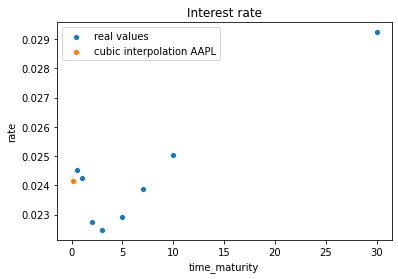

In [36]:
sns.scatterplot(x='tenor_float',y='rate',data=interestdf[interestdf.date == datadata.date.unique()[0]])
sns.scatterplot(x='time_maturity',y='rate',data=datadata[datadata.date == datadata.date.unique()[0]])
plt.legend(['real values','cubic interpolation AAPL'])
plt.title('Interest rate')

In [37]:
datadata.groupby('underlying').date.value_counts().mean()

265.81909547738695

In [39]:
df_cleaniqr = datadata[datadata.underlying == 'AAPL']
df_cleaniqr = df_cleaniqr[df_cleaniqr.date == df_cleaniqr.date.iloc[0]]
df_cleaniqr.loc[:,'price'] = df_cleaniqr['price'].mean()
print(len(df_cleaniqr))
df_cleaniqr = drop_tails(df_cleaniqr,limitstd=3)
print(len(df_cleaniqr))

215
208


In [40]:
from sklearn.cluster import DBSCAN

def dbscan_od(df,
              columns=['strike', 'eu_price', 'iv', 'time_maturity','rate', 'dividend'], 
              limitstd=3):
    outlier_detection = DBSCAN(
        eps = 0.9,
        metric="euclidean",
        min_samples = 3,
        n_jobs = -1)
    clusters = outlier_detection.fit_predict(df[columns])
    print(sum(clusters==-1))

    return df_cleaniqr[clusters !=-1]

#df_cleaniqr = dbscan_od(df_cleaniqr)
print(df_cleaniqr.shape)

(208, 12)


In [42]:
# df_agg = datadata.groupby('underlying').agg([np.median,np.max,np.std,np.min,stats.kurtosis]).dropna()
# #df_agg = StandardScaler().fit_transform(df_agg)
# pca = PCA(n_components=5)
# principalComponents = pca.fit_transform(df_agg)
# pca.explained_variance_ratio_

# from sklearn.cluster import SpectralClustering
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import AffinityPropagation


# # clustering = SpectralClustering(n_clusters=10, assign_labels="discretize",random_state=0).fit(df_agg)
# clustering = AffinityPropagation().fit(df_agg)
# clustering.labels_
# fst_cluster = np.array(df_agg.index)[clustering.labels_ == 0]
# df_0 = datadata[datadata.underlying.map(lambda x: x in fst_cluster)]

In [43]:
def generate_training_set(df_cleaniqr, batch = None):
    
    X_bw = df_cleaniqr[['rate','dividend','time_maturity']].copy()
    X_bw.loc[:,'moneyness'] = (df_cleaniqr['price'])/(df_cleaniqr['strike'])
    X_bw.loc[:,'sig'] = X_bw.loc[:,'th'] = X_bw.loc[:,'eta'] = 1
    X_bw.loc[:,'rho'] = 1
    X_bw.loc[:,'ka'] =  1
    Y_bw = df_cleaniqr['iv'].values
    X_bw = X_bw[['sig','th','ka','rho','eta','moneyness','rate','dividend','time_maturity']].values
    X_train_bw, y_train_bw = [tf.convert_to_tensor(x_set,dtype='float32') for x_set in [X_bw, Y_bw]]
    train_bw = tf.data.Dataset.from_tensor_slices((X_train_bw,y_train_bw)).shuffle(500)
    if batch:
        return train_bw.batch(batch)
    return train_bw
train_bw = generate_training_set(df_cleaniqr,64)


In [44]:
def has_converged(count,loss,prev_loss, thresshold):
    if prev_loss - loss < thresshold:
        return count+1,loss
    return 0,loss

In [82]:
def calibrate_heston(EPOCHS, train_bw, initial = [.5,.5,.5,-.5,.5]):

    temp_weights = model.get_weights()
    temp_weights[0][0]=np.array(initial,'float32')
    model.set_weights(temp_weights)
    t0 = time()
    prev_loss = 1000
    count = 0
    for epoch in range(EPOCHS):
        # Reset the metrics at the start of the next epoch
        bw_loss.reset_states()
        bw_mae.reset_states()
        bw_mape.reset_states()

        for data, target in train_bw:
            backward_step(data, target)

#         if epoch%1000 == 0:
#             template = 'Epoch %s:\nLoss: %f, MAE: %.6f, MAPE: %.4f, '
#             print(template % (epoch+1, bw_loss.result(), bw_mae.result(), bw_mape.result(),))
        count, prev_loss = has_converged(count, bw_loss.result(),prev_loss,5e-5)
        if count>3:
            break

    template = 'Epoch %s:\nLoss: %f, MAE: %.6f, MAPE: %.4f\
            \n_____________________________________'

    print(template % (epoch+1, bw_loss.result(), bw_mae.result(), bw_mape.result()))

    speed = time()-t0
    print('time: ',speed)
    return speed, epoch+1, bw_loss.result().numpy(), bw_mae.result().numpy(), bw_mape.result().numpy()

    
with tf.device("/gpu:0"):
    print(calibrate_heston(100, train_bw))
    

Epoch 55:
Loss: 0.001996, MAE: 0.036859, MAPE: 12.0266            
_____________________________________
time:  0.5991852283477783
(0.5991852283477783, 55, 0.0019963179, 0.03685905, 12.026598)


## Calibrating using the imported libraries

In [55]:
from tools.ann import Ann

In [78]:
import os
os.chdir("C:/Users/raul/Documents/workspace/MAI/Riskconcile/riskconcile")

In [79]:
loaded_model = Ann(5, 4)

In [84]:
loaded_model.calibrate(df_cleaniqr)

([0.31363717, 0.712962, 0.30614492, -0.6628288, 0.30831212], 0.0018156748, 64)

In [ ]:
print('Parameter layer')
print(model.layers[0].weights[0].numpy())
print('Hidden layer weights')
print(model.layers[-2].weights[0].numpy()[0][:10])

In [ ]:
plot_params(model.get_weights()[0][0] ,df_cleaniqr)

In [ ]:
from IPython.display import display

In [ ]:
T = df_cleaniqr.time_maturity.unique()[:2]

In [ ]:
%matplotlib inline
results = pd.DataFrame(columns=['underlying','time','MSE','MAE','MAPE','nrows','epochs','run', 
                                'sig', 'th', 'ka', 'rho', 'eta'])
for und, df_cleaniqr in datadata.groupby('underlying'):
    run = 0
    # Average the prices
    df_cleaniqr = drop_tails(df_cleaniqr, limitstd=2)
    nrows = df_cleaniqr.shape[0]
    print("Underlying Asset: %s, Number Of Rows: %s" % (und,nrows))
    # Calibrate with full data
    train_bw = generate_training_set(df_cleaniqr,batch=64)
    speed, epochs, res_loss, res_mae, res_mape = calibrate_heston(100, train_bw)
    params = list(model.get_weights()[0][0])
    results.loc[results.shape[0]] = [und, speed, res_loss, res_mae, res_mape, nrows, epochs, run] + params
    
    for cdate, df_date in df_cleaniqr.sort_values('date').groupby('date'):
        print(cdate,und)
        run += 1
        nrows = df_date.shape[0]
        train_bw = generate_training_set(df_date)
        speed, epochs, res_loss, res_mae, res_mape = calibrate_heston(100, train_bw, initial=params)
        params = list(model.get_weights()[0][0])
        results.loc[results.shape[0]] = [und, speed, res_loss, res_mae, res_mape, nrows, epochs, run] + params
        plot_params(params,df_date)
        

    
        
#     try:
        
#         for fecha in datadata.date.unique():
#             df_cleaniqr = df_cleaniqr[df_cleaniqr.date == fecha]
#             df_cleaniqr = drop_tails(df_cleaniqr, limitstd=3)
#             nrows = df_cleaniqr.shape[0]
#             print("Underlying Asset: %s, Number Of Rows: %s" % (und,nrows))
#             train_bw = generate_training_set(df_cleaniqr, batch=4)
#             speed, epochs, res_loss, res_mae, res_mape = calibrate_heston(100, train_bw, initial=model.get_weights()[0][0])





#             plot_params(model.get_weights()[0][0] ,df_cleaniqr)
#             results.loc[results.shape[0]] = [und, speed, res_loss, res_mae, res_mape, nrows, epochs]
#     except:
#         pass

In [ ]:
#['underlying','time','MSE','MAE','MAPE','nrows','epochs','run','sig', 'th', 'ka', 'rho', 'eta']
def form_graph():
    return plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')


results.describe()

In [ ]:
form_graph()
sns.lineplot(x="run", y="MSE", hue="underlying",data=results).set_title('Mean Squared Error on time')

In [ ]:
form_graph()
sns.lineplot(x="run", y="time", hue="underlying",data=results).set_title("Calibration Time Evolution")

In [ ]:
form_graph()
for parameter in ['sig', 'th', 'ka', 'rho', 'eta']:
    plt.figure()
    sns.lineplot(x="run", y=parameter, hue="underlying",data=results)

In [ ]:
form_graph()
results['epochs'] = results.epochs.astype(int)
sns.lineplot(x="run", y="epochs", hue="underlying",data=results).set_title("Evolutions of epochs needed for convergence")

In [ ]:
form_graph()
sns.barplot(x="run", y="nrows", hue="underlying",data=results).set_title("Amount of data on each run")

In [ ]:
form_graph()
sns.boxplot(x="run", y="MSE",data=results).set_title("Boxplot of evolution of MSE")

In [ ]:
form_graph()
sns.boxplot(x="underlying", y="MAPE",data=results).set_title("MSE boxplot per asset")

In [ ]:
form_graph()
sns.heatmap(results.corr()).set_title('General correlations')

In [ ]:
form_graph()
sns.heatmap(results[['sig', 'th', 'ka', 'rho', 'eta']].corr()).set_title('Parameters correlations')

In [ ]:
form_graph()
sns.heatmap(results[['sig', 'th', 'ka', 'rho', 'eta','MSE','MAE','MAPE']].corr()[['MSE','MAE','MAPE']].iloc[:5]).set_title('Parameters vs. metrics')

In [ ]:
df_cleaniqr = datadata[datadata.underlying == 'AMZN']

In [ ]:
drop_tails(df_cleaniqr,columns=['strike'])

In [ ]:
z = np.abs(stats.zscore(df_cleaniqr[['strike']]))


In [ ]:
df_cleaniqr.shape

In [ ]:
len(df_cleaniqr[(z < 2).all(axis=1)])

In [ ]:
from scipy.optimize import differential_evolution
import numpy as np

In [ ]:
reg = tf.keras.regularizers.l1()

def generate_training_set_GED(df_cleaniqr):
    
    X_bw = df_cleaniqr[['rate','dividend','time_maturity']].copy()
    X_bw.loc[:,'moneyness'] = (df_cleaniqr['price'])/(df_cleaniqr['strike'])
    X_bw.loc[:,'sig']= X_bw.loc[:,'th']= X_bw.loc[:,'eta']= X_bw.loc[:,'rho']= X_bw.loc[:,'ka'] =  1
    Y_bw = df_cleaniqr['iv'].values
    X_bw = X_bw[['sig','th','ka','rho','eta','moneyness','rate','dividend','time_maturity']].values
#     X_train_bw, y_train_bw = [tf.convert_to_tensor(x_set,dtype='float32') for x_set in [X_bw, Y_bw]]
    return X_bw, Y_bw

def assign_params(params, data_x, data_y):
    data_x[:,0], data_x[:,1], data_x[:,2], data_x[:,3], data_x[:,4] = params
    return [tf.convert_to_tensor(x_set,dtype='float32') for x_set in [data_x, data_y]]
    
def recip(params,data_x,data_y):
    data_x,data_y = assign_params(params,data_x,data_y)
#     return (tf.math.reduce_mean(tf.math.square(model(data_x)-tf.reshape(data_y,(data_y.shape[0],1))))-reg(tf.constant(params,dtype='float32'))).numpy()
    return (tf.math.reduce_mean(tf.math.square(model(data_x)-tf.reshape(data_y,(data_y.shape[0],1))))).numpy()

In [ ]:
from multiprocessing import Pool

In [ ]:
bounds = ((.2, .8),(.01, .8),(0.1, 2),( -.9, 0),( 0.01, .5))
df_cleaniqr = datadata[datadata.underlying == 'AMZN']
data_x, data_y = generate_training_set_GED(df_cleaniqr)
t0 = time()

with tf.device("/gpu:0"):
    res = differential_evolution(recip,bounds=bounds,args=([data_x, data_y]),popsize=50,workers=2)

print("time it took:",time()-t0)
res

In [ ]:
plot_params(res.x ,df_cleaniqr)